## 練習時間
將你的結果存成 csv, 上傳你的第一份 Kaggle 成績

Hints: https://stackoverflow.com/questions/16923281/pandas-writing-dataframe-to-csv-file

# [作業目標]
- 檢視並重新執行腳本, 試著將執行結果存檔並提交到 Kaggle 上

# [作業重點]
- 執行後, 將所得結果, 存成可以提交的 csv 檔 (In[10]) (Hint : 使用 pandas.DataFreame.to_csv)

# [提醒]
- 執行後, 將所得結果, 存成可以提交的 csv 檔 (In[10]) (Hint : 使用 pandas.DataFreame.to_csv)

In [14]:
# 載入需要的套件
import os
import time
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 仿造之前做過的處理

In [2]:
# 設定 data_path
dir_data = '../../data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

# 讀取檔案
app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

In [3]:
# 種類 2 種以下的類別型欄位轉標籤編碼 (Label Encoding)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # 紀錄有多少個 columns 被標籤編碼過
            le_count += 1
            
# 標籤編碼 (2種類別) 欄位轉 One Hot Encoding            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

### 做好前處理
開始擬合模型之前，我們要確保 training & testing data 的欄位數量一致，原因是因為 One hot encoding 會製造多的欄位，有些類別出現在 training data 而沒有出現 testing data 中，我們就要把這些多餘的欄位去除

In [5]:
train_labels = app_train['TARGET']

# 調整欄位數, 移除出現在 training data 而沒有出現 testing data 中的欄位
app_train, app_test = app_train.align(app_test, join='inner', axis=1)

In [36]:
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,0,1,0,1,0,False
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,1,0,0,0,0,0,0,1,0,False
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,0,False
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,0,0,0,False
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,0,0,0,False


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer as Imputer

# 特徵欄位清單
train = app_train
features = list(train.columns)

# 複製 test 資料
test = app_test.copy()

# 填補器 : 設定缺失值補中位數
imputer = Imputer(strategy='median')

# 縮放器 : 設定特徵縮放到 0~1 區間
scaler = MinMaxScaler(feature_range=(0, 1))

# 填補器載入個欄中位數
imputer.fit(train)

# 將中位數回填 train, test 資料中的空缺值
train = imputer.transform(train)
test = imputer.transform(app_test)

# 縮放器載入 train 的上下限, 對 train, test 進行縮放轉換
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


### Fit the model

In [11]:
def print_best_score(gsearch, param_test):
    print("Best score: %0.3f" % gsearch.best_score_)
    print("Best parameters set:")
    best_parameters = gsearch.best_estimator_.get_params()
    for param_name in sorted(param_test.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [13]:
import multiprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

%%time
# 設定模型與模型參數
log_reg = LogisticRegression(C=0.0001, n_jobs=multiprocessing.cpu_count())
param_test = {
    'warm_start': [True, False], 
    'tol': [0.01, 0.001, 0.0001],
}
gsearch = GridSearchCV(
    log_reg, 
    param_grid=param_test, 
    scoring='roc_auc', 
    cv=5, 
    n_jobs=multiprocessing.cpu_count())

# 使用 Train 資料訓練模型
gsearch.fit(train, train_labels)
print_best_score(gsearch, param_test)

Best score: 0.685
Best parameters set:
	tol: 0.01
	warm_start: True


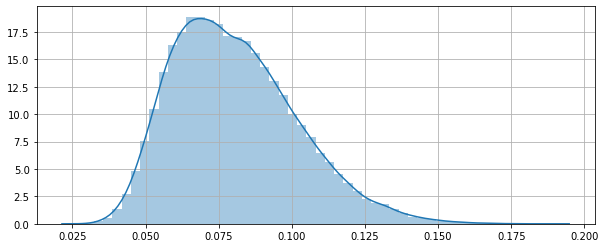

In [18]:
# 用模型預測結果
# 請注意羅吉斯迴歸是分類預測 (會輸出 0 的機率, 與 1 的機率), 而我們只需要留下 1 的機率這排
log_reg_pred = gsearch.predict_proba(test)[:, 1]

plt.figure(figsize=(10, 4))
sns.distplot(log_reg_pred)
plt.grid()
plt.show()

In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(
    random_state=17, 
    slient=0, 
    n_jobs=multiprocessing.cpu_count())

param_test = { 
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [300, 400, 500],
    'max_depth': [10, 15, 20]
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

rsearch = RandomizedSearchCV(
    xgb, 
    param_distributions=param_test, 
    n_iter=5, 
    scoring='roc_auc', 
    n_jobs=multiprocessing.cpu_count(), 
    cv=skf.split(train, train_labels), 
    verbose=2, 
    random_state=17)

rsearch.fit(train, train_labels)
print_best_score(rsearch, param_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   8 out of  15 | elapsed: 36.7min remaining: 32.1min
[Parallel(n_jobs=16)]: Done  15 out of  15 | elapsed: 52.3min finished


Best score: 0.745
Best parameters set:
	learning_rate: 0.1
	max_depth: 10
	n_estimators: 300


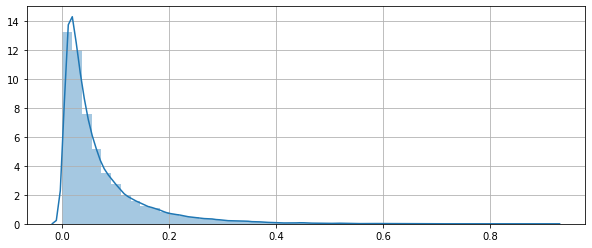

In [27]:
xgb_pred = rsearch.predict_proba(test)[:, 1]

plt.figure(figsize=(10, 4))
sns.distplot(xgb_pred)
plt.grid()
plt.show()

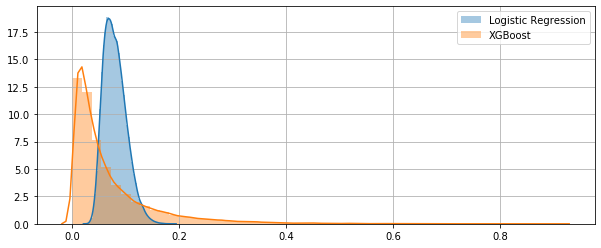

In [41]:
plt.figure(figsize=(10, 4))
sns.distplot(log_reg_pred, label="Logistic Regression")
sns.distplot(xgb_pred, label="XGBoost")
plt.grid()
plt.legend()
plt.show()

模型 fit 好以後，就可以用來預測 testing data 中的客戶違約遲繳貸款的機率咯! (記得要用 predict_proba 才會輸出機率)

### 儲存預測結果

In [31]:
# 計算提交結果
submit = app_test[['SK_ID_CURR']].copy()
submit['TARGET'] = xgb_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.003878
1,100005,0.069523
2,100013,0.004532
3,100028,0.008932
4,100038,0.071352


In [32]:
submit.shape

(48744, 2)

In [33]:
submit.to_csv("./xgb_submit.csv", index=False)